In [1]:
# system information
import os
from glob import glob

# computing 
import numpy as np
import pandas as pd
from datetime import datetime
import scipy as sp
import scipy.optimize as op
import statistics 
import seaborn as sb
from random import uniform, seed, random
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
%matplotlib inline

# ROOT files handling
import uproot as ur
import ROOT
from coffea.nanoevents import NanoEventsFactory, BaseSchema

Welcome to JupyROOT 6.26/06


In [2]:
# define ticks
def set_ticks(ax, xMaj, yMaj):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.minorticks_on()
    ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=14)
    ax.tick_params(which='minor', width=1.0, length=4, direction='in', labelsize=14)
    ax.yaxis.get_offset_text().set_fontsize(14)
    ax.xaxis.get_offset_text().set_fontsize(14)

## EXPONENTIAL MC

- Total number of events: 253946 
- Total acquisition time: 1118820 seconds
- Rate: 0.23 Hz


In [3]:
# seconds in one week
seconds_week = 7 * 24 * 3600
# how many weeks of acquisition?
weeks = 1118820 / seconds_week
n_tot = 253946
# baseline in one week
n_one_week = 253946/(weeks)

print("# events per week is: %1.4f" % int(n_one_week))

# events per week is: 137275.0000


In [3]:

y = 137275.0 / ( 1+1.266)
y,137275.0-y

(60580.31774051191, 76694.6822594881)

In [4]:
4*(2048-180)

7472

## TAC CALIBRATION PARAMETERS
Let's retrieve the TAC calibration parameters and the associated uncertainties

In [7]:
params = np.array([0.02588903364201166, 0.0117937685867166])
cov_matrix = np.array([[ 4.25606075e-05, -4.81971726e-08],[-4.81971726e-08,  8.43411455e-11]])

a, b = params[0], params[1]
err_a, err_b = np.sqrt(cov_matrix[0,0]), np.sqrt(cov_matrix[1,1])
cov_ab = cov_matrix[0,1]


def propagate_err(x, sigma_x, a, b, cov_matrix):
    '''
        Propagate error considering TAC cal.
        input:  * x values in ADC
                * sigma_x in ADC
                * calibration parameters a,b 
                * covariance matrix 
        output: uncertainty on y values in us
    '''

    err_a, err_b = np.sqrt(cov_matrix[0,0]), np.sqrt(cov_matrix[1,1])
    cov_ab = cov_matrix[0,1]
    var_y = err_a**2 + err_b**2 * x**2 + 2 * cov_ab * x + b**2 * sigma_x**2
    return np.sqrt(var_y)

def ToADC(t, a, b):
    '''
        Function to convert time in us to ADC
    '''
    adc = (t - a)/ b
    return adc

def ToTime(adc, a, b):
    '''
        Function to convert time in ADC to us
    '''
    y = a + b * adc
    return y

In [10]:
## ---- Constants ---- ##
tau_short = 0.8466      # [us]
tau_long = 2.1969811    # [us]

tau_s_adc = ToADC(0.8466, a, b)
tau_l_adc = ToADC(2.1969811, a, b)

print("tau_short in ADC: %1.1f \ntau_long in ADC: %1.1f"%(tau_s_adc,tau_l_adc))

tau_short in ADC: 69.6 
tau_long in ADC: 184.1


We will consider different time intervals according to $\tau_{short} \sim $ 70 ADC:

## Exponential simulation 
- For $\tau = \tau_{short}$ we will simulate the full spectrum (from 0 to 2048) according to an exponential distribution and then perform a fit on the full range. We used two methods: `TRandom:exp` and the inverse CDF sampling.

In [11]:
tree_tau_s = NanoEventsFactory.from_root('root_files/taushort_trandom.root', schemaclass = BaseSchema, treepath='expo_taushort').events()

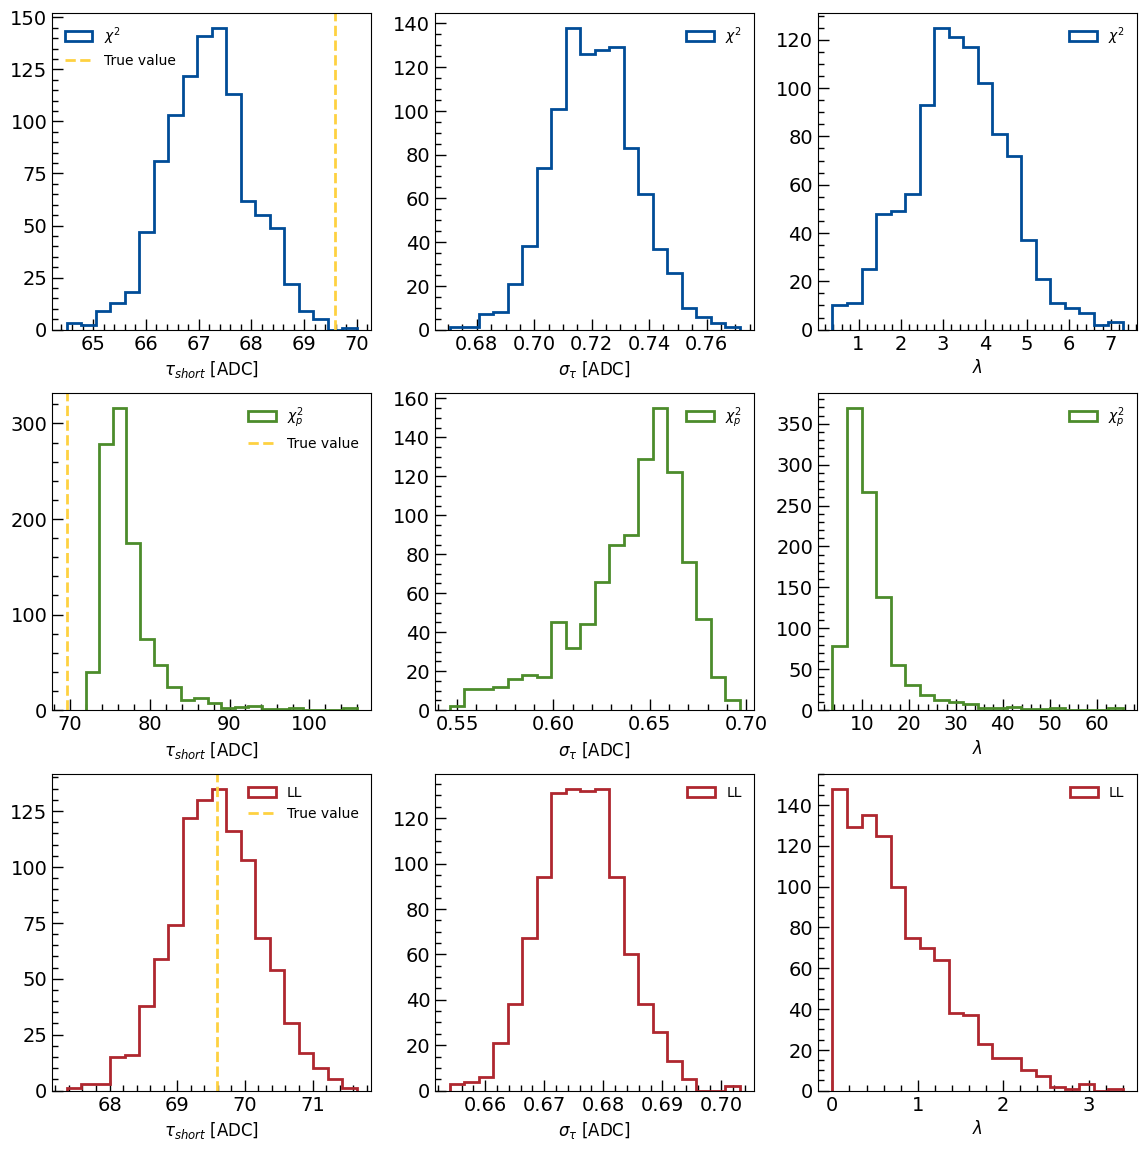

In [32]:
fig, ax = plt.subplots(3, 3, figsize = (14,14))

ax[0,0].hist(tree_tau_s.tau_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,1].hist(tree_tau_s.tau_chi_err, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,2].hist(tree_tau_s.delta_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')


ax[1,0].hist(tree_tau_s.tau_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,1].hist(tree_tau_s.tau_chip_err, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,2].hist(tree_tau_s.delta_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')

ax[2,0].hist(tree_tau_s.tau_LL, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,1].hist(tree_tau_s.tau_LL_err, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,2].hist(tree_tau_s.delta_L, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{short}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_s_adc, lw = 2, ls = '--', color = '#FED141', label = 'True value')

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].legend(loc='best', frameon=False, fontsize=10)


set_ticks(ax[0,0], 1, 25)
set_ticks(ax[0,1], 0.02, 20)
set_ticks(ax[0,2], 1, 20)
set_ticks(ax[1,0], 10,100)
set_ticks(ax[1,1], 0.05,20)
set_ticks(ax[1,2], 10,50)
set_ticks(ax[2,0], 1,25)
set_ticks(ax[2,1], 0.01,20)
set_ticks(ax[2,2], 1,20)


plt.show()

In [35]:
tree_tau_s = NanoEventsFactory.from_root('root_files/taushort_invcdf.root', schemaclass = BaseSchema, treepath='expo_taushort').events()
tree_tau_s301 = NanoEventsFactory.from_root('root_files/taushort_invcdf_301bins.root', schemaclass = BaseSchema, treepath='expo_taushort').events()
tree_tau_s400 = NanoEventsFactory.from_root('root_files/taushort_invcdf_400bins.root', schemaclass = BaseSchema, treepath='expo_taushort').events()
tree_tau_s500 = NanoEventsFactory.from_root('root_files/taushort_invcdf_500bins.root', schemaclass = BaseSchema, treepath='expo_taushort').events()
tree_tau_s600 = NanoEventsFactory.from_root('root_files/taushort_invcdf_600bins.root', schemaclass = BaseSchema, treepath='expo_taushort').events()
tree_tau_s800 = NanoEventsFactory.from_root('root_files/taushort_invcdf_800bins.root', schemaclass = BaseSchema, treepath='expo_taushort').events()
tree_tau_s1000 = NanoEventsFactory.from_root('root_files/taushort_invcdf_1000bins.root', schemaclass = BaseSchema, treepath='expo_taushort').events()
tree_tau_s1200 = NanoEventsFactory.from_root('root_files/taushort_invcdf_1200bins.root', schemaclass = BaseSchema, treepath='expo_taushort').events()


## Nbins = 1869

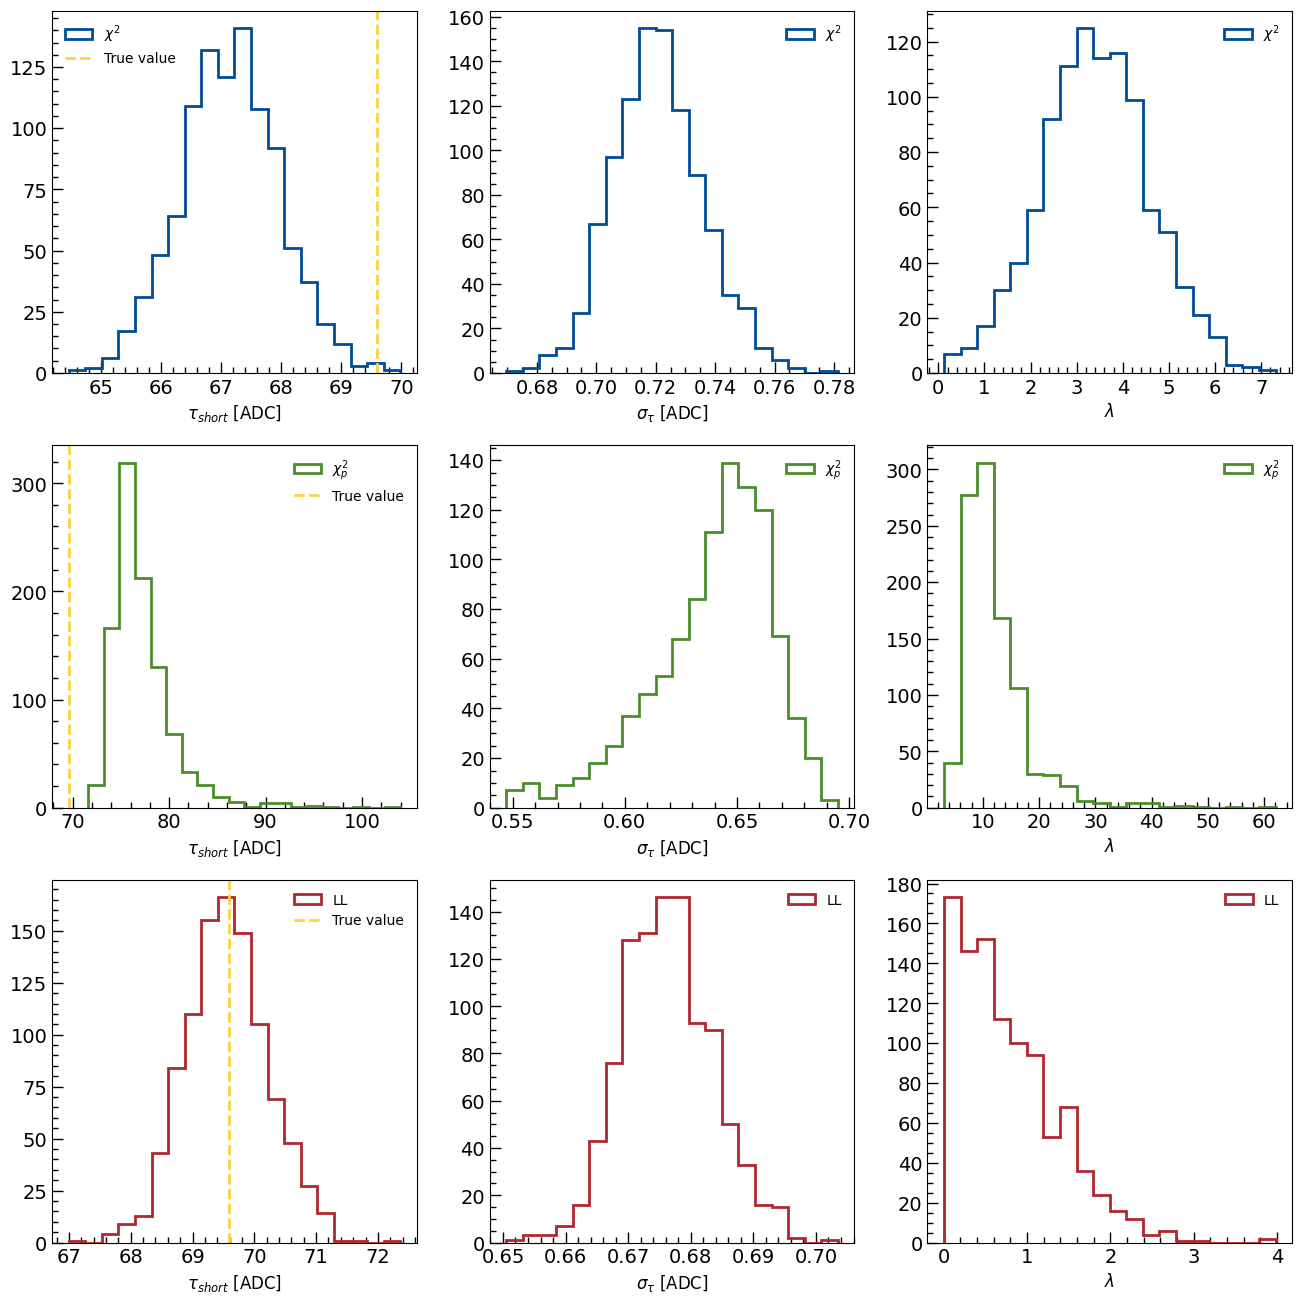

In [39]:
fig, ax = plt.subplots(3, 3, figsize = (16,16))

ax[0,0].hist(tree_tau_s.tau_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,1].hist(tree_tau_s.tau_chi_err, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,2].hist(tree_tau_s.delta_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')


ax[1,0].hist(tree_tau_s.tau_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,1].hist(tree_tau_s.tau_chip_err, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,2].hist(tree_tau_s.delta_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')

ax[2,0].hist(tree_tau_s.tau_LL, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,1].hist(tree_tau_s.tau_LL_err, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,2].hist(tree_tau_s.delta_L, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{short}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_s_adc, lw = 2, ls = '--', color = '#FED141', label = 'True value')

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].legend(loc='best', frameon=False, fontsize=10)


set_ticks(ax[0,0], 1, 25)
set_ticks(ax[0,1], 0.02, 20)
set_ticks(ax[0,2], 1, 20)
set_ticks(ax[1,0], 10,100)
set_ticks(ax[1,1], 0.05,20)
set_ticks(ax[1,2], 10,50)
set_ticks(ax[2,0], 1,25)
set_ticks(ax[2,1], 0.01,20)
set_ticks(ax[2,2], 1,20)


plt.show()

## Nbins = 1200

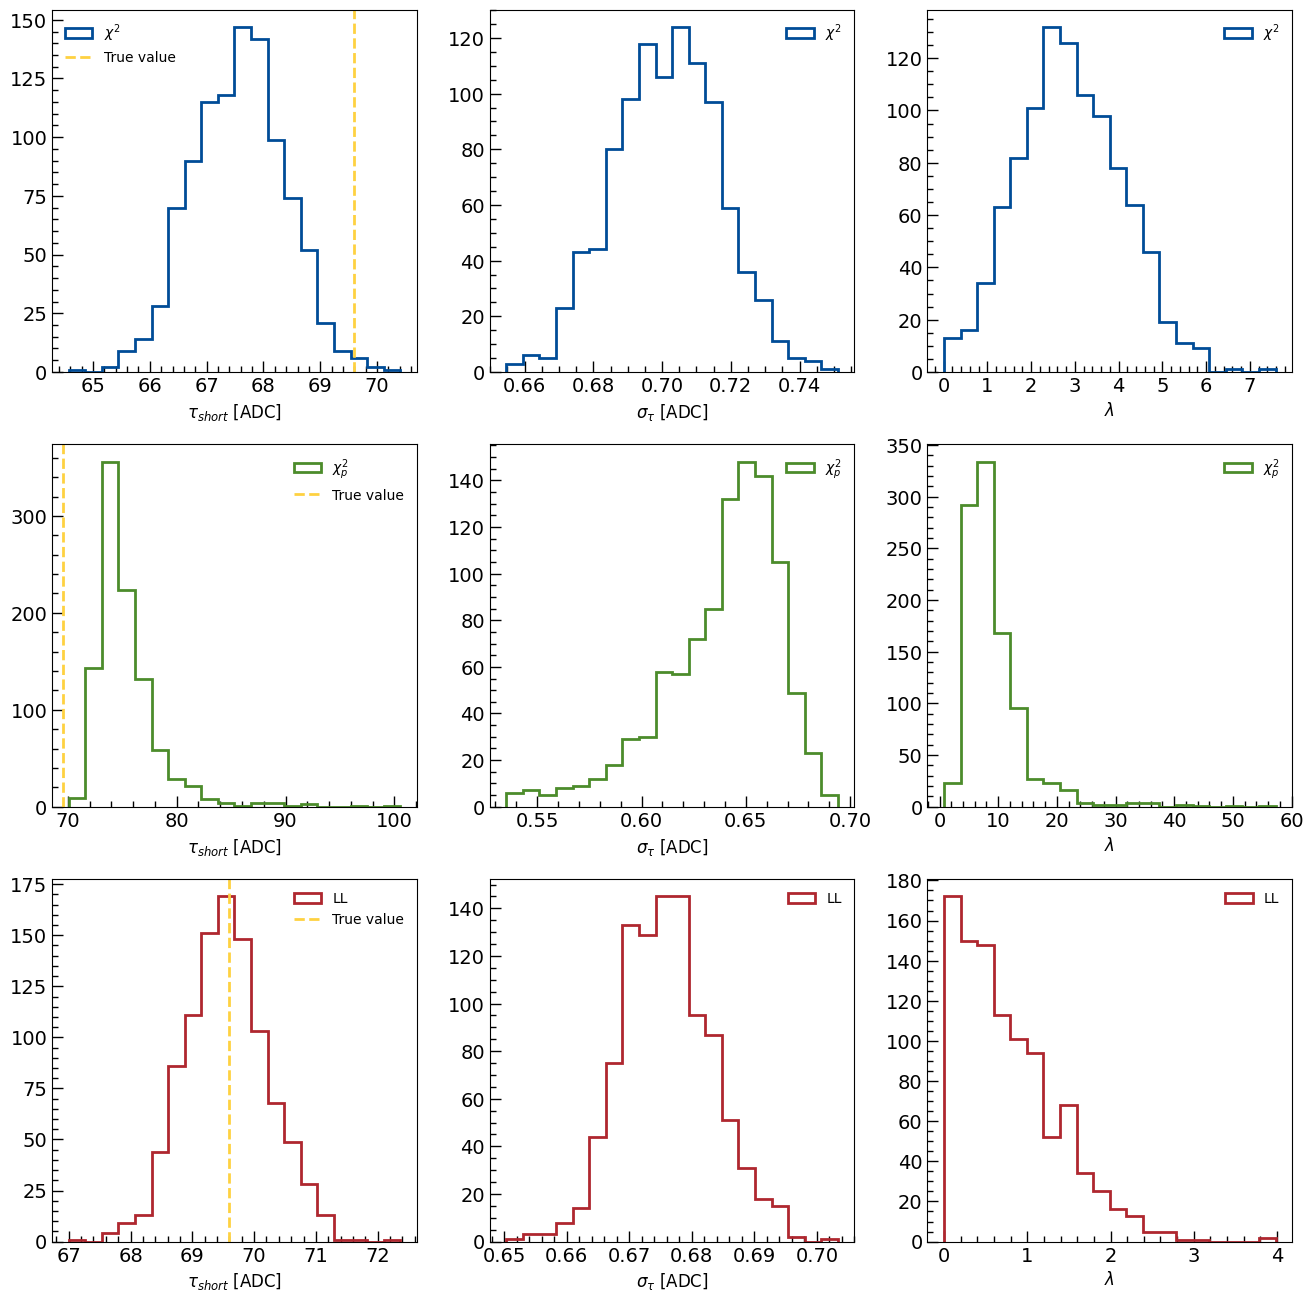

In [40]:
fig, ax = plt.subplots(3, 3, figsize = (16,16))

ax[0,0].hist(tree_tau_s1200.tau_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,1].hist(tree_tau_s1200.tau_chi_err, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,2].hist(tree_tau_s1200.delta_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')


ax[1,0].hist(tree_tau_s1200.tau_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,1].hist(tree_tau_s1200.tau_chip_err, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,2].hist(tree_tau_s1200.delta_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')

ax[2,0].hist(tree_tau_s1200.tau_LL, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,1].hist(tree_tau_s1200.tau_LL_err, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,2].hist(tree_tau_s1200.delta_L, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{short}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_s_adc, lw = 2, ls = '--', color = '#FED141', label = 'True value')

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].legend(loc='best', frameon=False, fontsize=10)


set_ticks(ax[0,0], 1, 25)
set_ticks(ax[0,1], 0.02, 20)
set_ticks(ax[0,2], 1, 20)
set_ticks(ax[1,0], 10,100)
set_ticks(ax[1,1], 0.05,20)
set_ticks(ax[1,2], 10,50)
set_ticks(ax[2,0], 1,25)
set_ticks(ax[2,1], 0.01,20)
set_ticks(ax[2,2], 1,20)


plt.show()

## Nbins = 1000

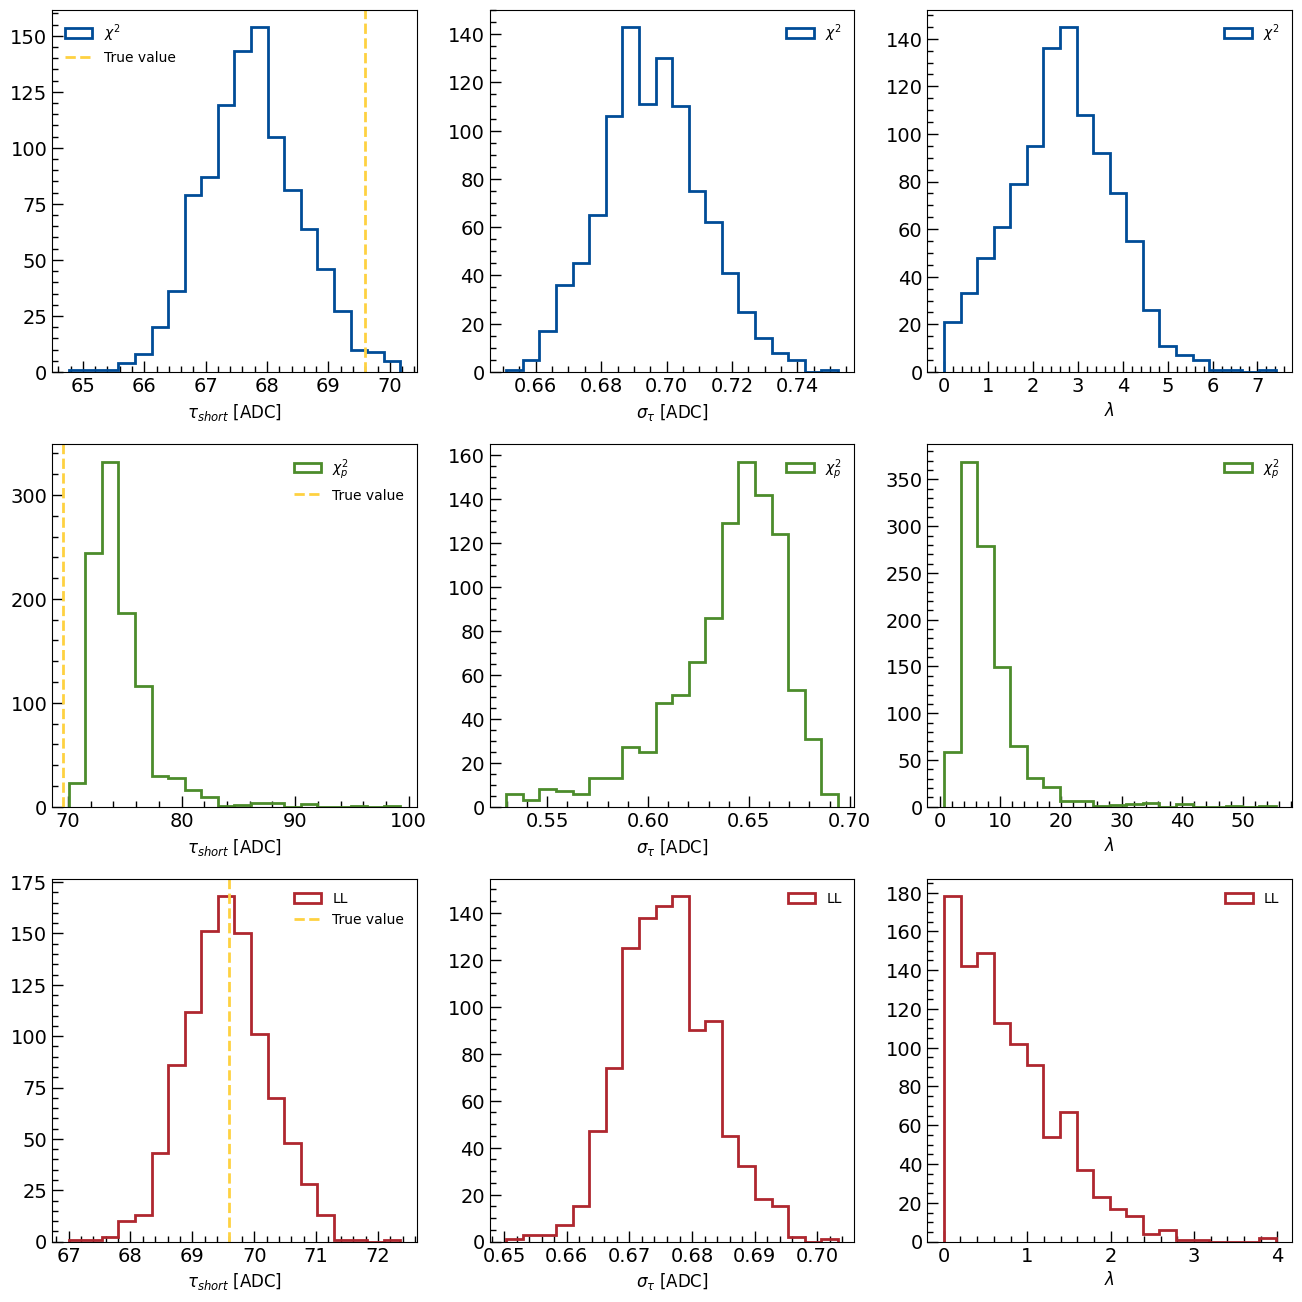

In [41]:
fig, ax = plt.subplots(3, 3, figsize = (16,16))

ax[0,0].hist(tree_tau_s1000.tau_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,1].hist(tree_tau_s1000.tau_chi_err, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,2].hist(tree_tau_s1000.delta_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')


ax[1,0].hist(tree_tau_s1000.tau_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,1].hist(tree_tau_s1000.tau_chip_err, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,2].hist(tree_tau_s1000.delta_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')

ax[2,0].hist(tree_tau_s1000.tau_LL, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,1].hist(tree_tau_s1000.tau_LL_err, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,2].hist(tree_tau_s1000.delta_L, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{short}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_s_adc, lw = 2, ls = '--', color = '#FED141', label = 'True value')

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].legend(loc='best', frameon=False, fontsize=10)


set_ticks(ax[0,0], 1, 25)
set_ticks(ax[0,1], 0.02, 20)
set_ticks(ax[0,2], 1, 20)
set_ticks(ax[1,0], 10,100)
set_ticks(ax[1,1], 0.05,20)
set_ticks(ax[1,2], 10,50)
set_ticks(ax[2,0], 1,25)
set_ticks(ax[2,1], 0.01,20)
set_ticks(ax[2,2], 1,20)


plt.show()

## Nbins = 800

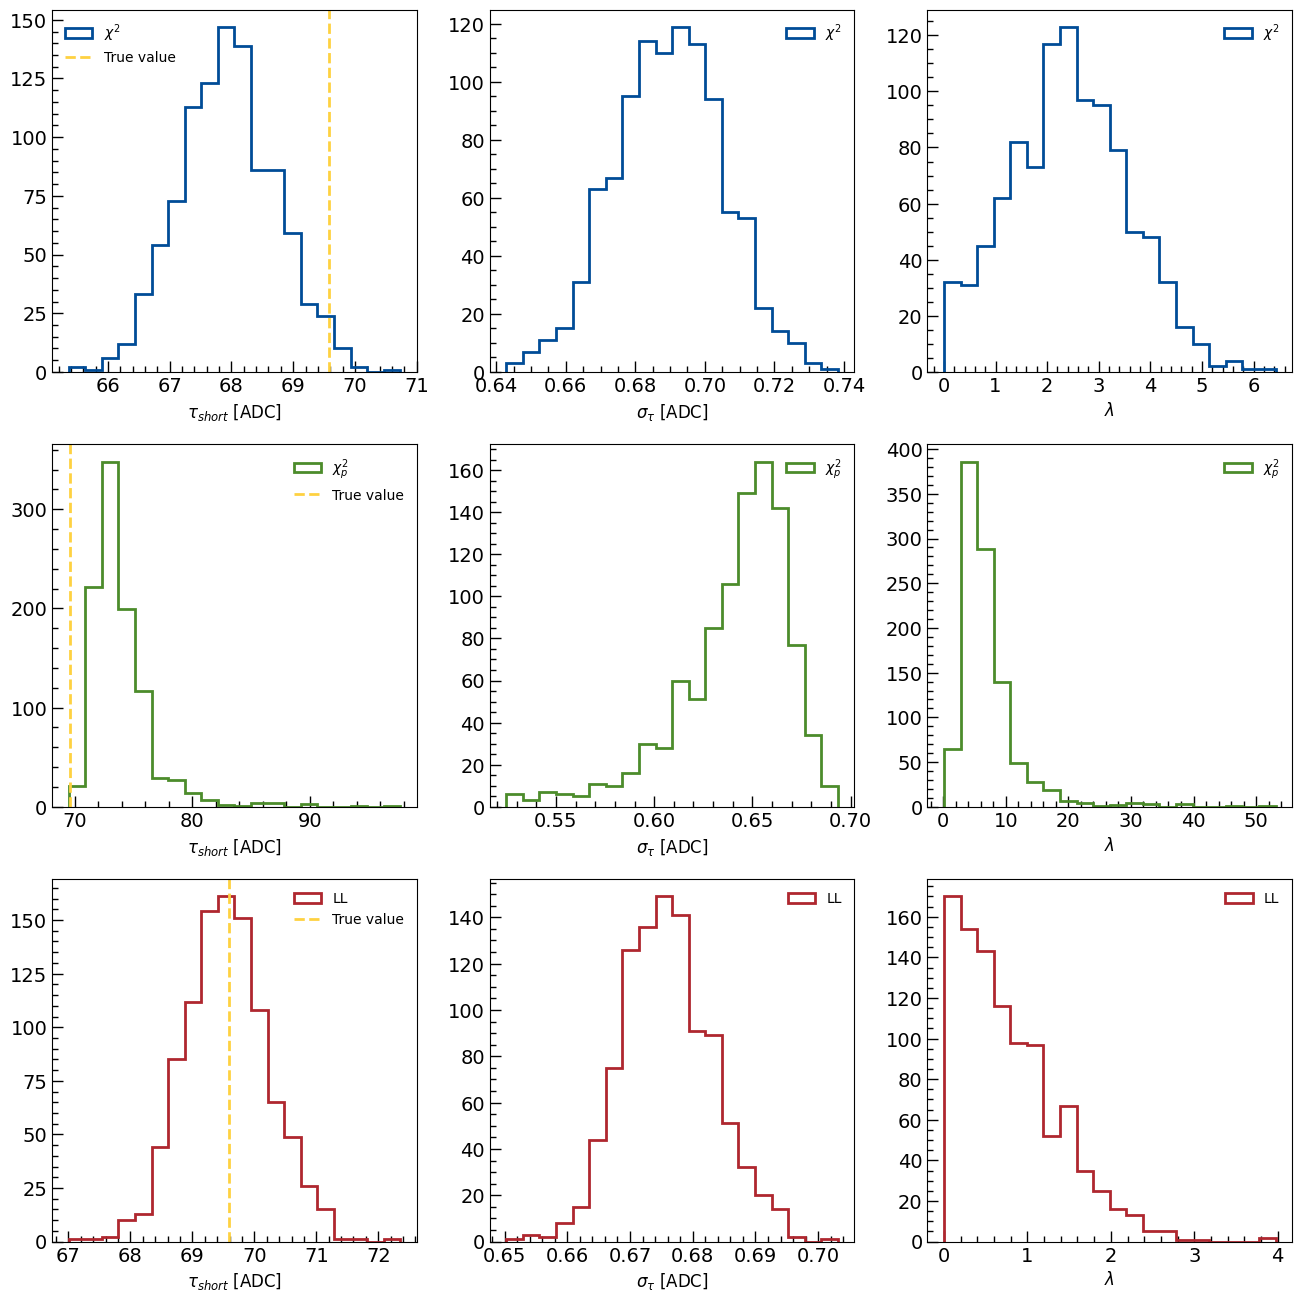

In [42]:
fig, ax = plt.subplots(3, 3, figsize = (16,16))

ax[0,0].hist(tree_tau_s800.tau_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,1].hist(tree_tau_s800.tau_chi_err, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,2].hist(tree_tau_s800.delta_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')


ax[1,0].hist(tree_tau_s800.tau_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,1].hist(tree_tau_s800.tau_chip_err, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,2].hist(tree_tau_s800.delta_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')

ax[2,0].hist(tree_tau_s800.tau_LL, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,1].hist(tree_tau_s800.tau_LL_err, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,2].hist(tree_tau_s800.delta_L, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{short}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_s_adc, lw = 2, ls = '--', color = '#FED141', label = 'True value')

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].legend(loc='best', frameon=False, fontsize=10)


set_ticks(ax[0,0], 1, 25)
set_ticks(ax[0,1], 0.02, 20)
set_ticks(ax[0,2], 1, 20)
set_ticks(ax[1,0], 10,100)
set_ticks(ax[1,1], 0.05,20)
set_ticks(ax[1,2], 10,50)
set_ticks(ax[2,0], 1,25)
set_ticks(ax[2,1], 0.01,20)
set_ticks(ax[2,2], 1,20)


plt.show()

## Nbins = 600

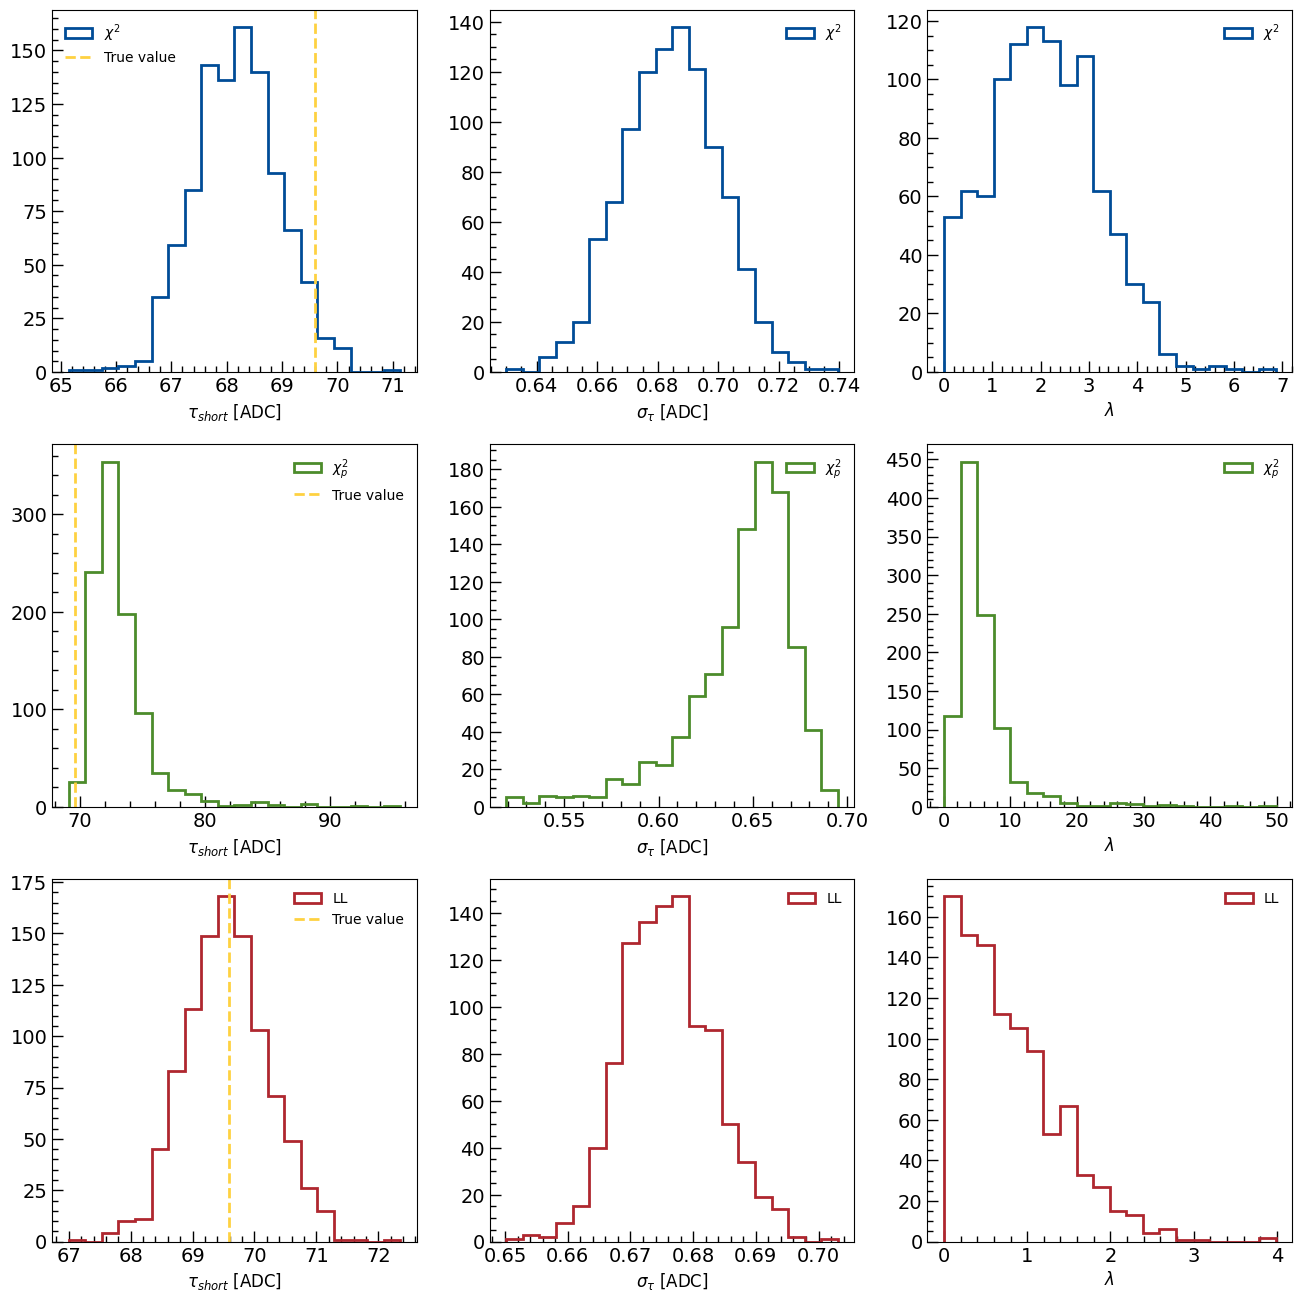

In [43]:
fig, ax = plt.subplots(3, 3, figsize = (16,16))

ax[0,0].hist(tree_tau_s600.tau_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,1].hist(tree_tau_s600.tau_chi_err, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,2].hist(tree_tau_s600.delta_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')


ax[1,0].hist(tree_tau_s600.tau_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,1].hist(tree_tau_s600.tau_chip_err, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,2].hist(tree_tau_s600.delta_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')

ax[2,0].hist(tree_tau_s600.tau_LL, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,1].hist(tree_tau_s600.tau_LL_err, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,2].hist(tree_tau_s600.delta_L, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{short}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_s_adc, lw = 2, ls = '--', color = '#FED141', label = 'True value')

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].legend(loc='best', frameon=False, fontsize=10)


set_ticks(ax[0,0], 1, 25)
set_ticks(ax[0,1], 0.02, 20)
set_ticks(ax[0,2], 1, 20)
set_ticks(ax[1,0], 10,100)
set_ticks(ax[1,1], 0.05,20)
set_ticks(ax[1,2], 10,50)
set_ticks(ax[2,0], 1,25)
set_ticks(ax[2,1], 0.01,20)
set_ticks(ax[2,2], 1,20)


plt.show()

## Nbins = 500

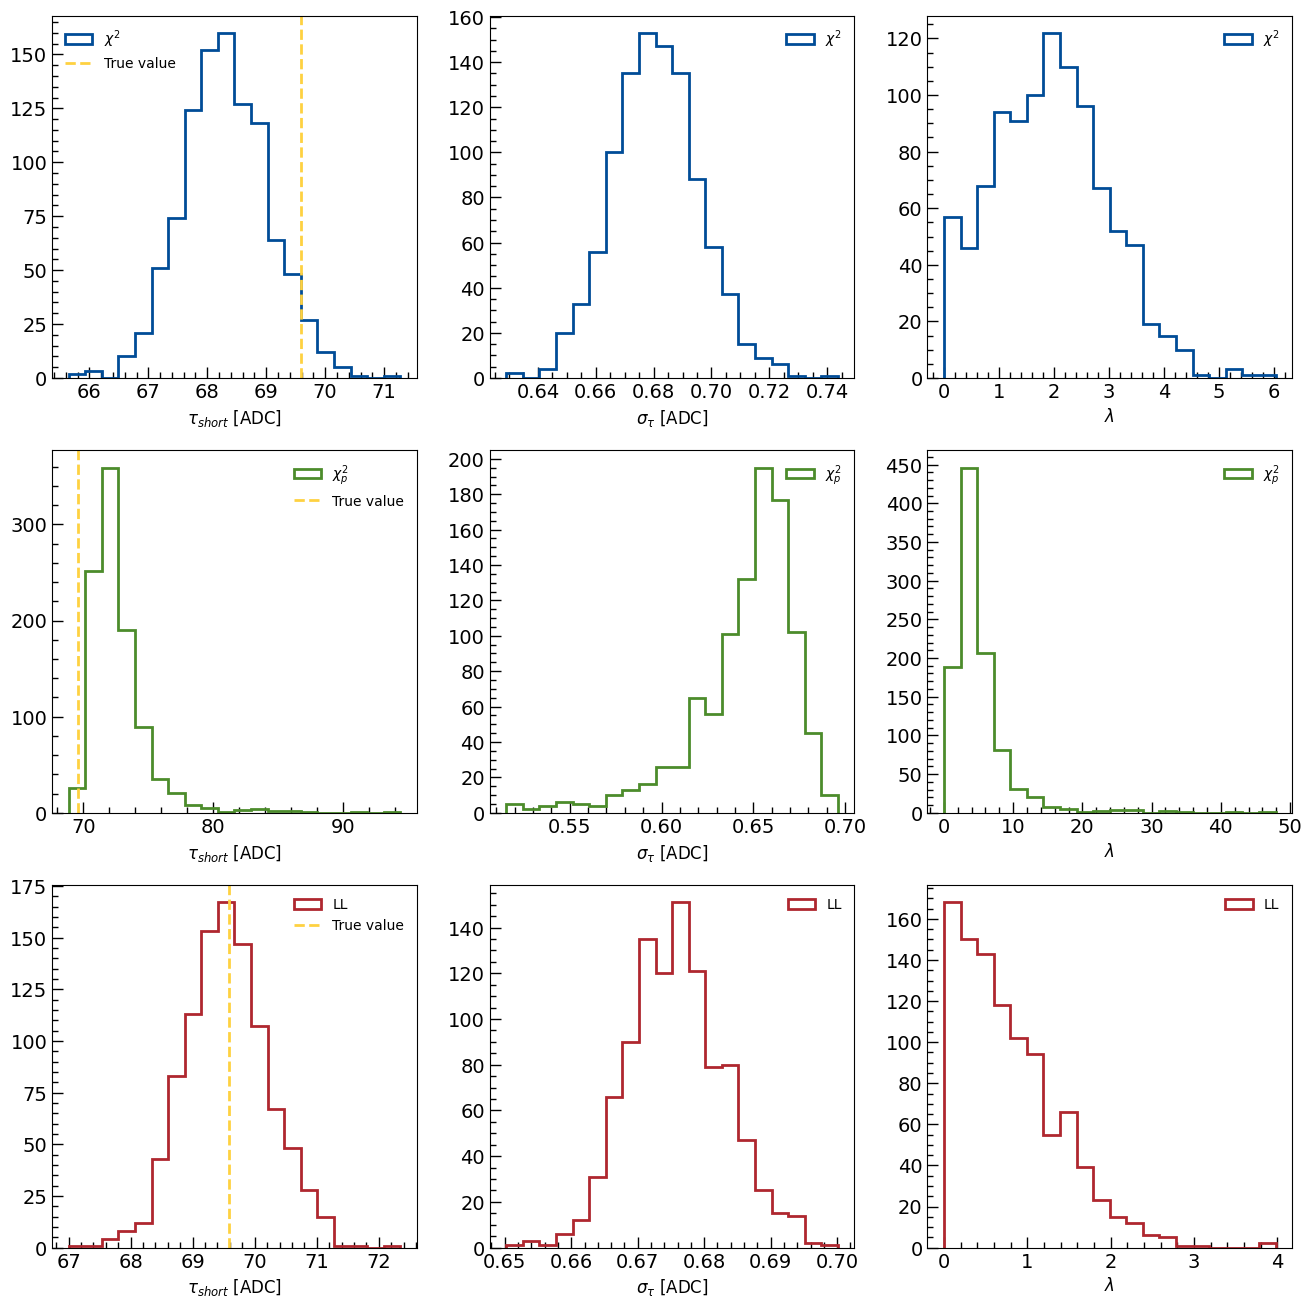

In [44]:
fig, ax = plt.subplots(3, 3, figsize = (16,16))

ax[0,0].hist(tree_tau_s500.tau_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,1].hist(tree_tau_s500.tau_chi_err, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,2].hist(tree_tau_s500.delta_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')


ax[1,0].hist(tree_tau_s500.tau_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,1].hist(tree_tau_s500.tau_chip_err, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,2].hist(tree_tau_s500.delta_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')

ax[2,0].hist(tree_tau_s500.tau_LL, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,1].hist(tree_tau_s500.tau_LL_err, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,2].hist(tree_tau_s500.delta_L, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{short}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_s_adc, lw = 2, ls = '--', color = '#FED141', label = 'True value')

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].legend(loc='best', frameon=False, fontsize=10)


set_ticks(ax[0,0], 1, 25)
set_ticks(ax[0,1], 0.02, 20)
set_ticks(ax[0,2], 1, 20)
set_ticks(ax[1,0], 10,100)
set_ticks(ax[1,1], 0.05,20)
set_ticks(ax[1,2], 10,50)
set_ticks(ax[2,0], 1,25)
set_ticks(ax[2,1], 0.01,20)
set_ticks(ax[2,2], 1,20)


plt.show()

## Nbins = 400

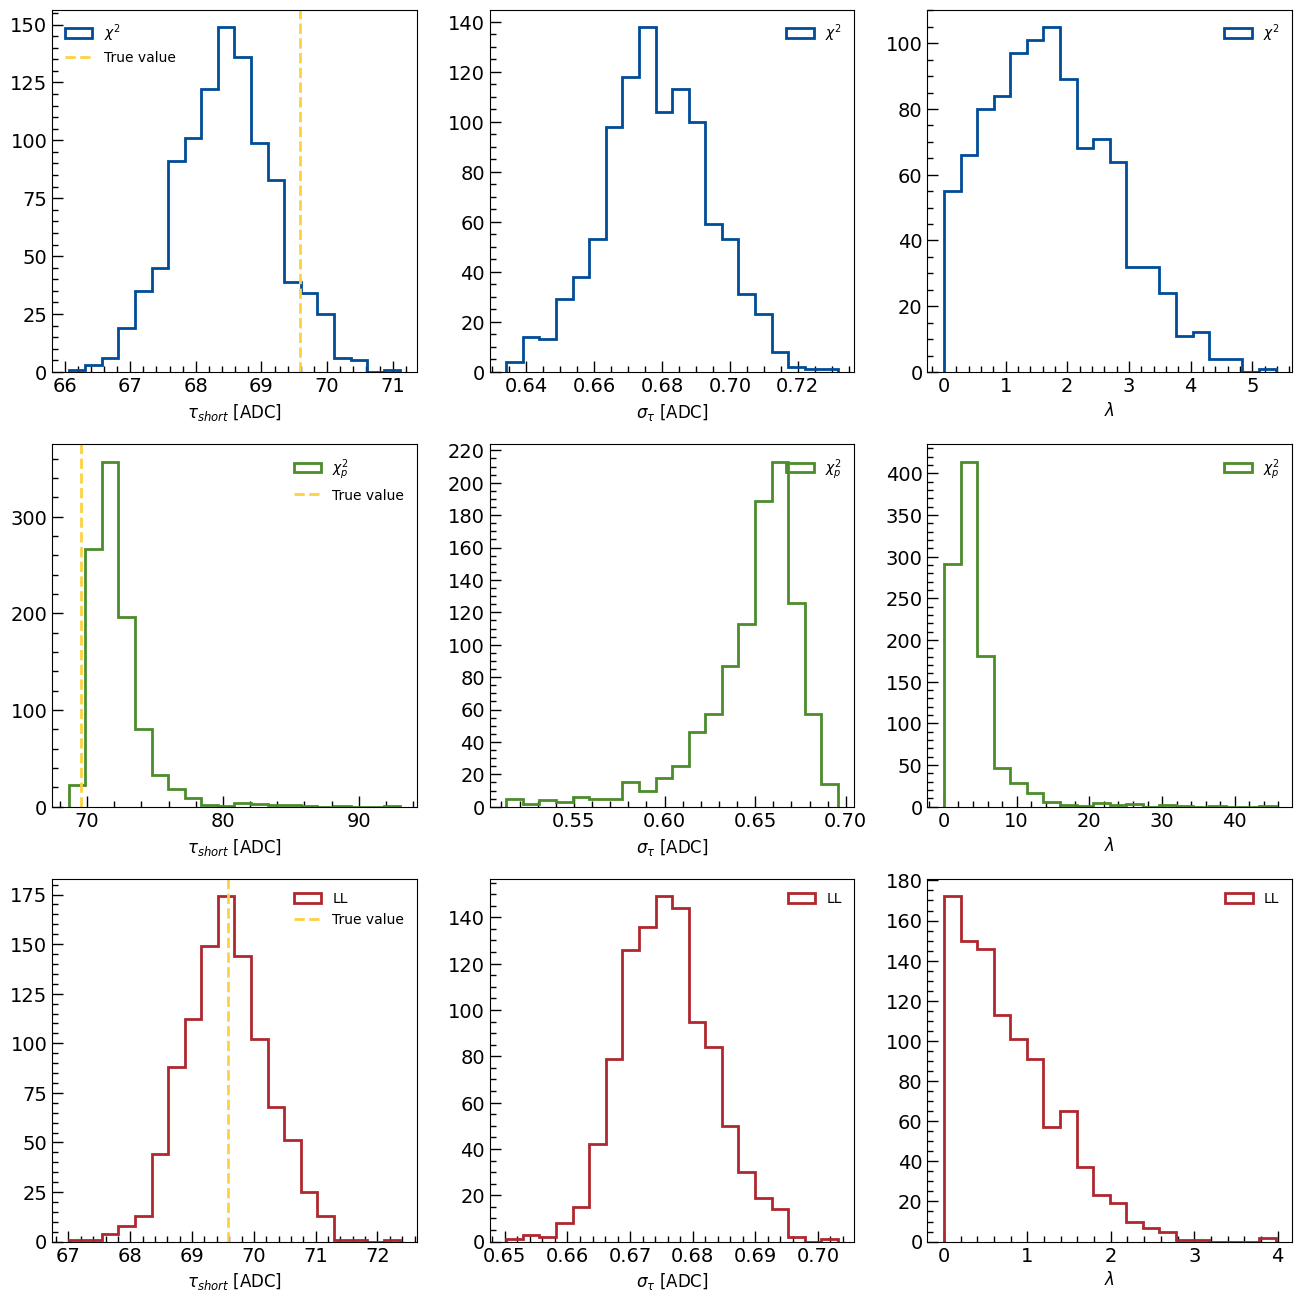

In [45]:
fig, ax = plt.subplots(3, 3, figsize = (16,16))

ax[0,0].hist(tree_tau_s400.tau_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,1].hist(tree_tau_s400.tau_chi_err, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,2].hist(tree_tau_s400.delta_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')


ax[1,0].hist(tree_tau_s400.tau_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,1].hist(tree_tau_s400.tau_chip_err, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,2].hist(tree_tau_s400.delta_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')

ax[2,0].hist(tree_tau_s400.tau_LL, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,1].hist(tree_tau_s400.tau_LL_err, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,2].hist(tree_tau_s400.delta_L, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{short}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_s_adc, lw = 2, ls = '--', color = '#FED141', label = 'True value')

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].legend(loc='best', frameon=False, fontsize=10)


set_ticks(ax[0,0], 1, 25)
set_ticks(ax[0,1], 0.02, 20)
set_ticks(ax[0,2], 1, 20)
set_ticks(ax[1,0], 10,100)
set_ticks(ax[1,1], 0.05,20)
set_ticks(ax[1,2], 10,50)
set_ticks(ax[2,0], 1,25)
set_ticks(ax[2,1], 0.01,20)
set_ticks(ax[2,2], 1,20)


plt.show()

## Nbins = 301

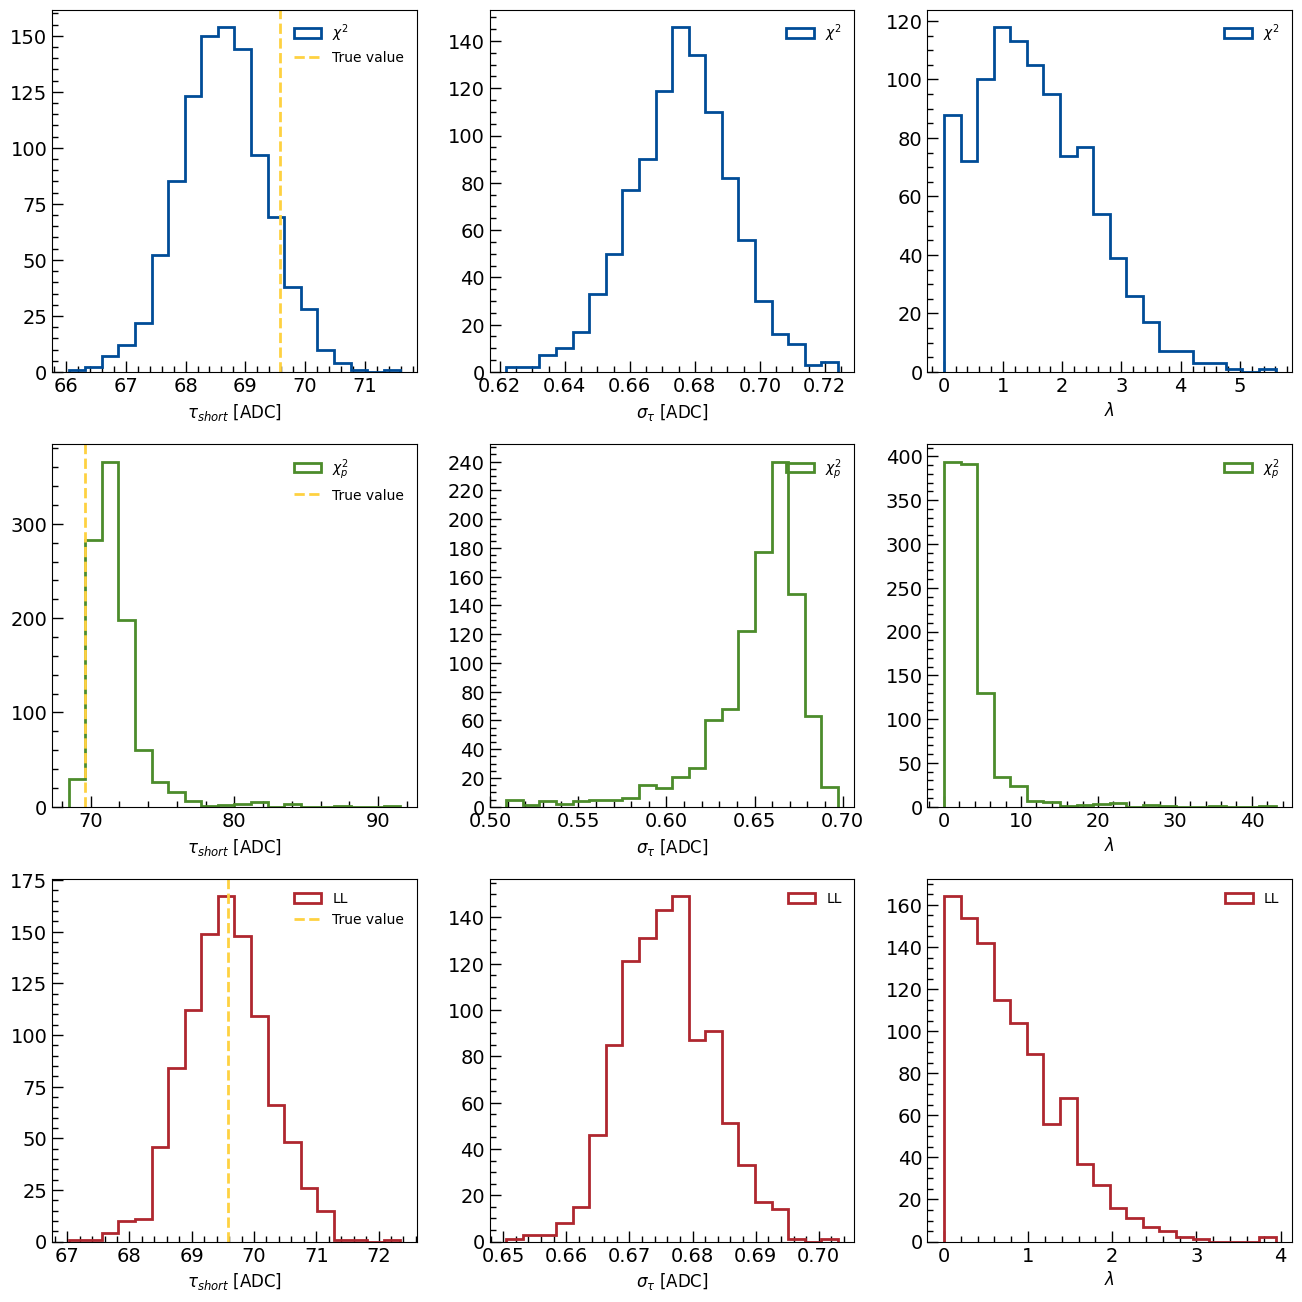

In [46]:
fig, ax = plt.subplots(3, 3, figsize = (16,16))

ax[0,0].hist(tree_tau_s301.tau_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,1].hist(tree_tau_s301.tau_chi_err, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')
ax[0,2].hist(tree_tau_s301.delta_chi, bins=20, histtype='step', ec = '#004C97', lw=2, alpha=1, align = 'mid', label = '$\chi^2$')


ax[1,0].hist(tree_tau_s301.tau_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,1].hist(tree_tau_s301.tau_chip_err, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')
ax[1,2].hist(tree_tau_s301.delta_chip, bins=20, histtype='step', ec = '#4C8C2B', lw=2, alpha=1, align = 'mid', label = '$\chi_p^2$')

ax[2,0].hist(tree_tau_s301.tau_LL, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,1].hist(tree_tau_s301.tau_LL_err, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')
ax[2,2].hist(tree_tau_s301.delta_L, bins=20, histtype='step', ec = '#AF272F', lw=2, alpha=1, align = 'mid', label = 'LL')


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{short}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_s_adc, lw = 2, ls = '--', color = '#FED141', label = 'True value')

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].legend(loc='best', frameon=False, fontsize=10)


set_ticks(ax[0,0], 1, 25)
set_ticks(ax[0,1], 0.02, 20)
set_ticks(ax[0,2], 1, 20)
set_ticks(ax[1,0], 10,100)
set_ticks(ax[1,1], 0.05,20)
set_ticks(ax[1,2], 10,50)
set_ticks(ax[2,0], 1,25)
set_ticks(ax[2,1], 0.01,20)
set_ticks(ax[2,2], 1,20)


plt.show()

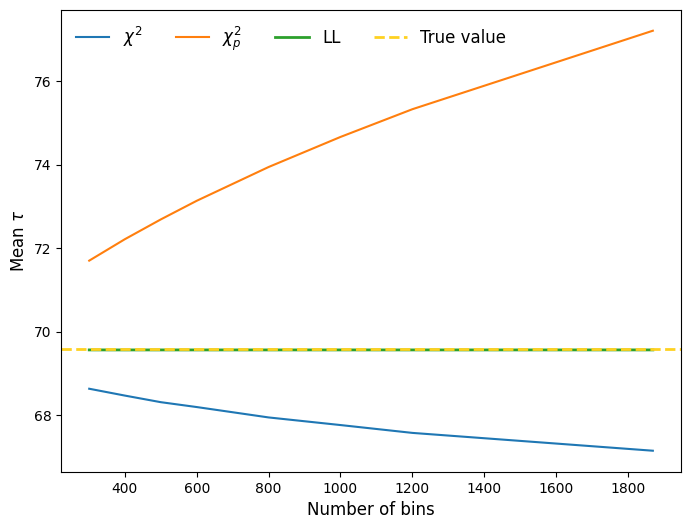

In [74]:
plt.figure(figsize=(8,6))

x = [301, 400, 500, 600, 800, 1000, 1200, 1869]

y = [tree_tau_s301.tau_chi, tree_tau_s400.tau_chi, tree_tau_s500.tau_chi, 
    tree_tau_s600.tau_chi, tree_tau_s800.tau_chi, tree_tau_s1000.tau_chi, tree_tau_s1200.tau_chi, tree_tau_s.tau_chi]

y_p = [tree_tau_s301.tau_chip, tree_tau_s400.tau_chip, tree_tau_s500.tau_chip, 
    tree_tau_s600.tau_chip, tree_tau_s800.tau_chip, tree_tau_s1000.tau_chip, tree_tau_s1200.tau_chip, tree_tau_s.tau_chip]

y_LL = [tree_tau_s301.tau_LL, tree_tau_s400.tau_LL, tree_tau_s500.tau_LL, 
    tree_tau_s600.tau_LL, tree_tau_s800.tau_LL, tree_tau_s1000.tau_LL, tree_tau_s1200.tau_LL, tree_tau_s.tau_LL]

plt.plot(x,np.mean(y, axis = 1), label = '$\chi^2$')
plt.plot(x,np.mean(y_p, axis = 1), label = '$\chi_p^2$')
plt.plot(x,np.mean(y_LL, axis = 1), label = 'LL', lw = 2)

plt.xlabel('Number of bins', size= 12)
plt.ylabel('Mean $\\tau$',  size= 12)

plt.axhline(tau_s_adc, lw = 2, ls = '--', color = '#FED121', label = 'True value')
plt.legend(loc='best', frameon=False, fontsize=12, ncol = 4)

plt.show()

- For $\tau = \tau_{long}$ we will simulate the full spectrum (from 0 to 2048) according to an exponential distribution and then perform a fit on the different ranges ( only inverse CDF sampling)
  - Range 1: [$5\cdot\tau_{long}$, 2048]
  - Range 2: [$6\cdot\tau_{long}$, 2048]
  - ...
  - Range n: [$9\cdot\tau_{long}$, 2048]

In [235]:
tree_tau_l = NanoEventsFactory.from_root('root_files/taulong_invcdf.root', schemaclass = BaseSchema, treepath='expo_taulong').events()

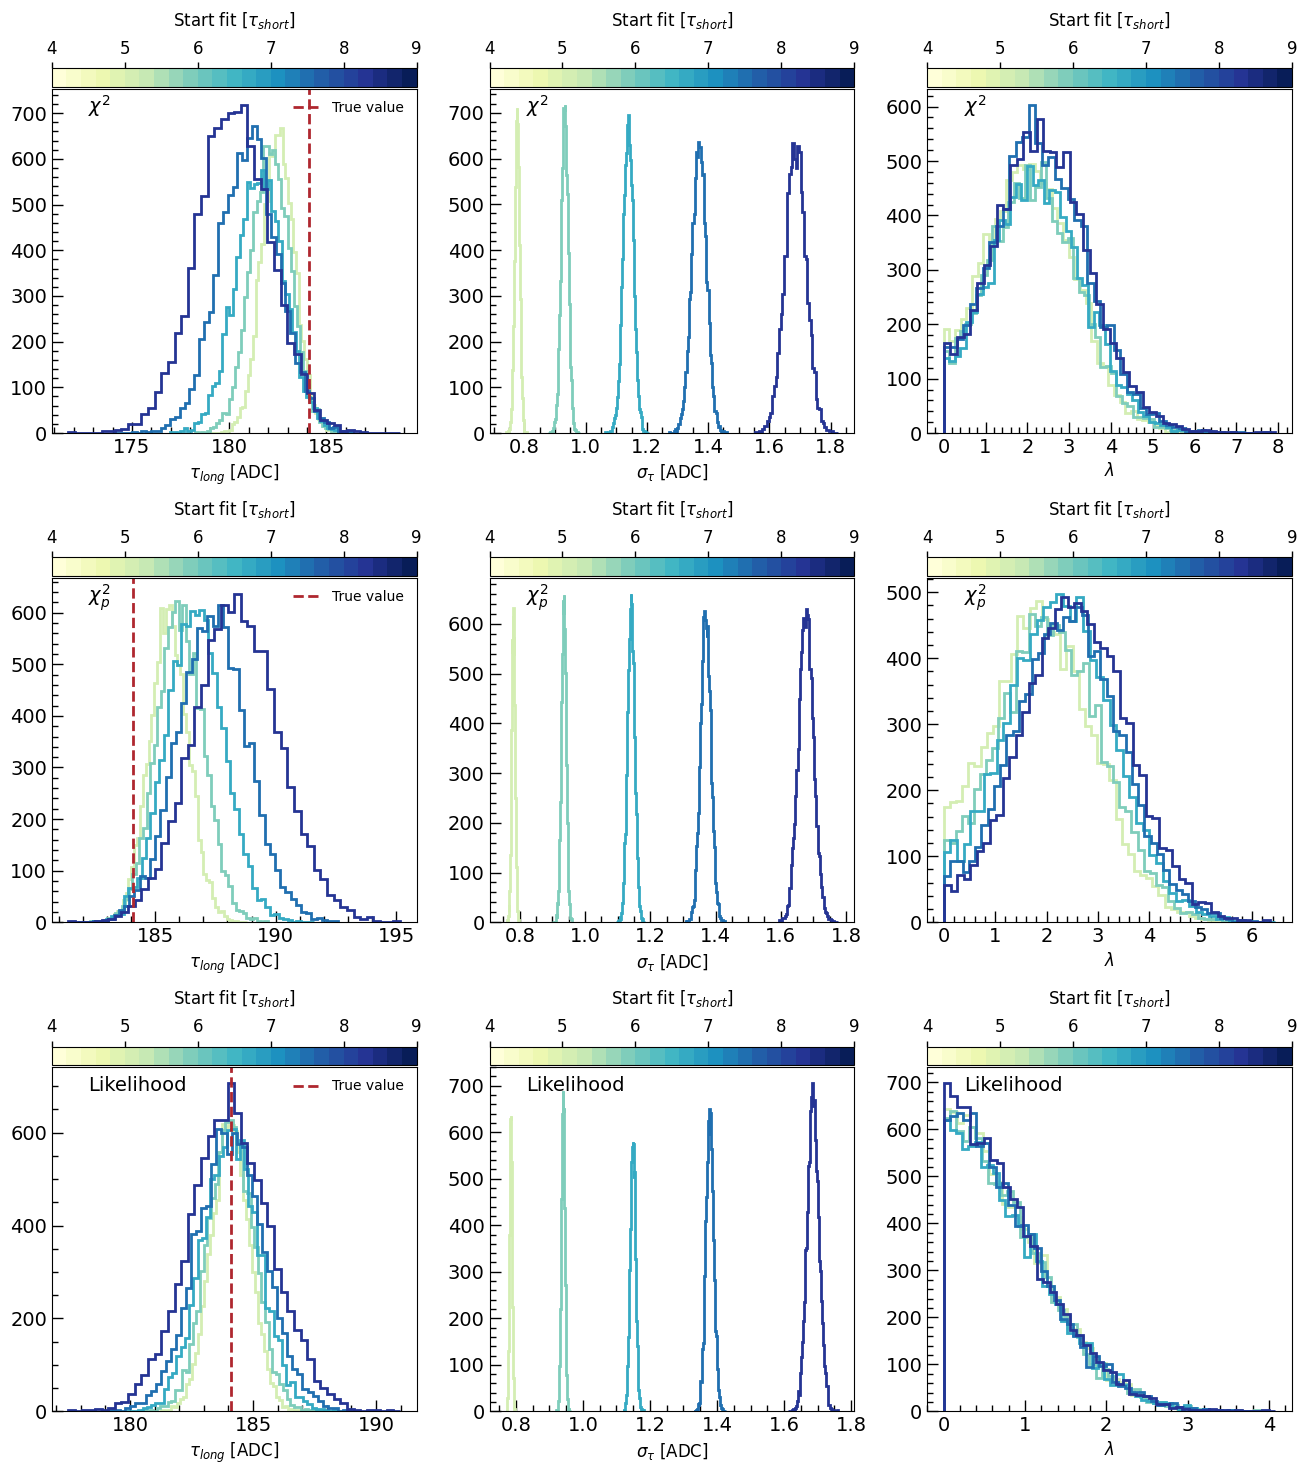

In [236]:
fig, ax = plt.subplots(3, 3, figsize = (16,18))


import matplotlib as mpl
c = np.arange(4,10)


#labels = ['$5\\tau$', '$6\\tau$', '$7\\tau$', '$8\\tau$', '$9\\tau$']
labels = ['$\chi^2$', '$\chi^2_p$', 'Likelihood']

for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',25)
    # Make dummie mappable
    dummie_cax = ax[0,k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[0,k].cla()  
    for i in range(0,5): 
        if k == 0: ax[0,k].hist(tree_tau_l.tau_chi[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 1: ax[0,k].hist(tree_tau_l.tau_chi_err[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 2: ax[0,k].hist(tree_tau_l.delta_chi[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[0,k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{short}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)


for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',25)
    # Make dummie mappable
    dummie_cax = ax[1,k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[1,k].cla()  
    for i in range(0,5): 
        if k == 0: ax[1,k].hist(tree_tau_l.tau_chip[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 1: ax[1,k].hist(tree_tau_l.tau_chip_err[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 2: ax[1,k].hist(tree_tau_l.delta_chip[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[1,k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{short}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)


for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',25)
    # Make dummie mappable
    dummie_cax = ax[2,k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[2,k].cla()  
    for i in range(0,5): 
        if k == 0: ax[2,k].hist(tree_tau_l.tau_LL[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 1: ax[2,k].hist(tree_tau_l.tau_LL_err[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 2: ax[2,k].hist(tree_tau_l.delta_L[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[2,k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{short}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{long}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_l_adc, lw = 2, ls = '--', color = '#AF272F', label = 'True value')
    ax[i,0].legend(loc='upper right', frameon=False, fontsize=10)

    ax[i,0].text(0.1, 0.93, labels[i], fontsize = 14, transform = ax[i,0].transAxes)
    ax[i,1].text(0.1, 0.93, labels[i], fontsize = 14, transform = ax[i,1].transAxes)
    ax[i,2].text(0.1, 0.93, labels[i], fontsize = 14, transform = ax[i,2].transAxes)

set_ticks(ax[0,0], 5, 100)
set_ticks(ax[0,1], 0.2, 100)
set_ticks(ax[0,2], 1, 100)
set_ticks(ax[1,0], 5,100)
set_ticks(ax[1,1], 0.2,100)
set_ticks(ax[1,2], 1,100)
set_ticks(ax[2,0], 5,200)
set_ticks(ax[2,1], 0.2,100)
set_ticks(ax[2,2], 1,100)

#fig.savefig('tau_long_exp.pdf', dpi = 200)
plt.show()

In [237]:
tree_tau_l = NanoEventsFactory.from_root('root_files/taulong_invcdf.root', schemaclass = BaseSchema, treepath='expo_taulong_v2').events()

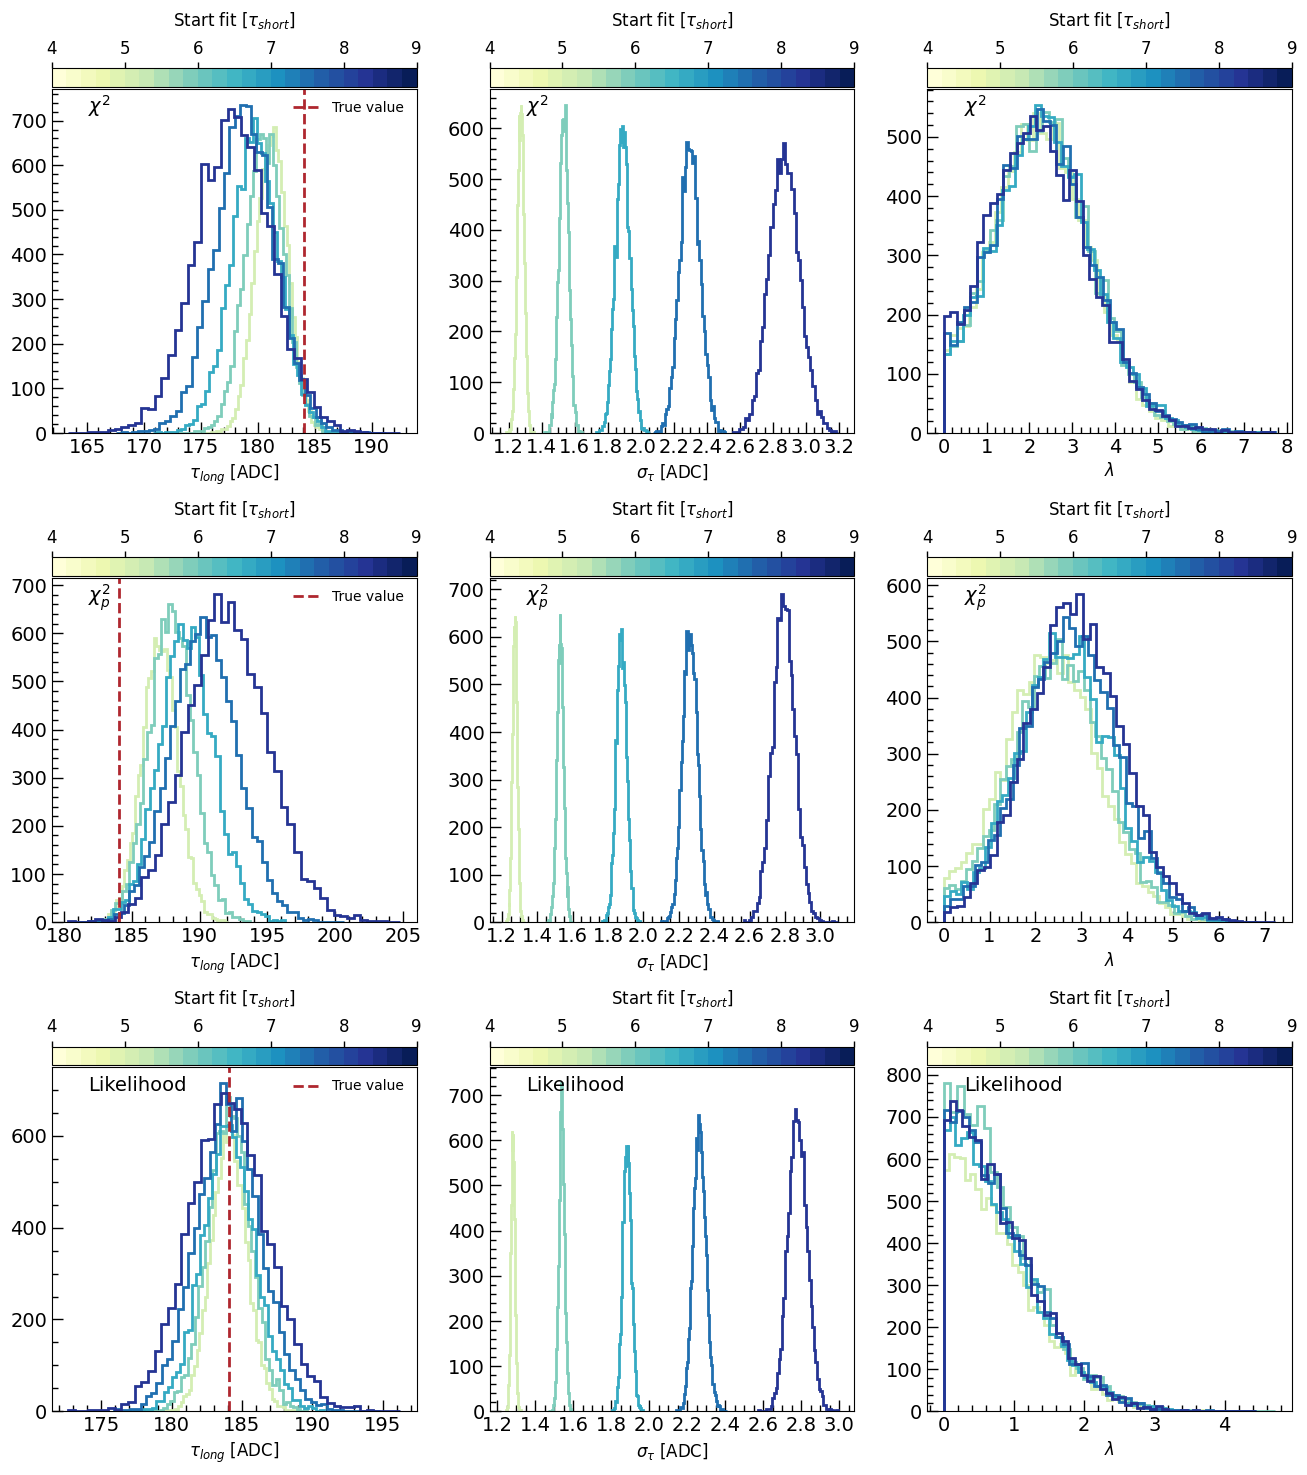

In [238]:
fig, ax = plt.subplots(3, 3, figsize = (16,18))


import matplotlib as mpl
c = np.arange(4,10)


#labels = ['$5\\tau$', '$6\\tau$', '$7\\tau$', '$8\\tau$', '$9\\tau$']
labels = ['$\chi^2$', '$\chi^2_p$', 'Likelihood']

for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',25)
    # Make dummie mappable
    dummie_cax = ax[0,k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[0,k].cla()  
    for i in range(0,5): 
        if k == 0: ax[0,k].hist(tree_tau_l.tau_chi[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 1: ax[0,k].hist(tree_tau_l.tau_chi_err[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 2: ax[0,k].hist(tree_tau_l.delta_chi[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[0,k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{short}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)


for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',25)
    # Make dummie mappable
    dummie_cax = ax[1,k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[1,k].cla()  
    for i in range(0,5): 
        if k == 0: ax[1,k].hist(tree_tau_l.tau_chip[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 1: ax[1,k].hist(tree_tau_l.tau_chip_err[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 2: ax[1,k].hist(tree_tau_l.delta_chip[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[1,k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{short}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)


for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',25)
    # Make dummie mappable
    dummie_cax = ax[2,k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[2,k].cla()  
    for i in range(0,5): 
        if k == 0: ax[2,k].hist(tree_tau_l.tau_LL[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 1: ax[2,k].hist(tree_tau_l.tau_LL_err[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 2: ax[2,k].hist(tree_tau_l.delta_L[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[2,k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{short}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{long}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_l_adc, lw = 2, ls = '--', color = '#AF272F', label = 'True value')
    ax[i,0].legend(loc='upper right', frameon=False, fontsize=10)

    ax[i,0].text(0.1, 0.93, labels[i], fontsize = 14, transform = ax[i,0].transAxes)
    ax[i,1].text(0.1, 0.93, labels[i], fontsize = 14, transform = ax[i,1].transAxes)
    ax[i,2].text(0.1, 0.93, labels[i], fontsize = 14, transform = ax[i,2].transAxes)

set_ticks(ax[0,0], 5, 100)
set_ticks(ax[0,1], 0.2, 100)
set_ticks(ax[0,2], 1, 100)
set_ticks(ax[1,0], 5,100)
set_ticks(ax[1,1], 0.2,100)
set_ticks(ax[1,2], 1,100)
set_ticks(ax[2,0], 5,200)
set_ticks(ax[2,1], 0.2,100)
set_ticks(ax[2,2], 1,100)

#fig.savefig('tau_long_exp.pdf', dpi = 200)
plt.show()

In [239]:
tree_tau_l = NanoEventsFactory.from_root('root_files/taulong_invcdf.root', schemaclass = BaseSchema, treepath='expo_taulong_0.5N').events()

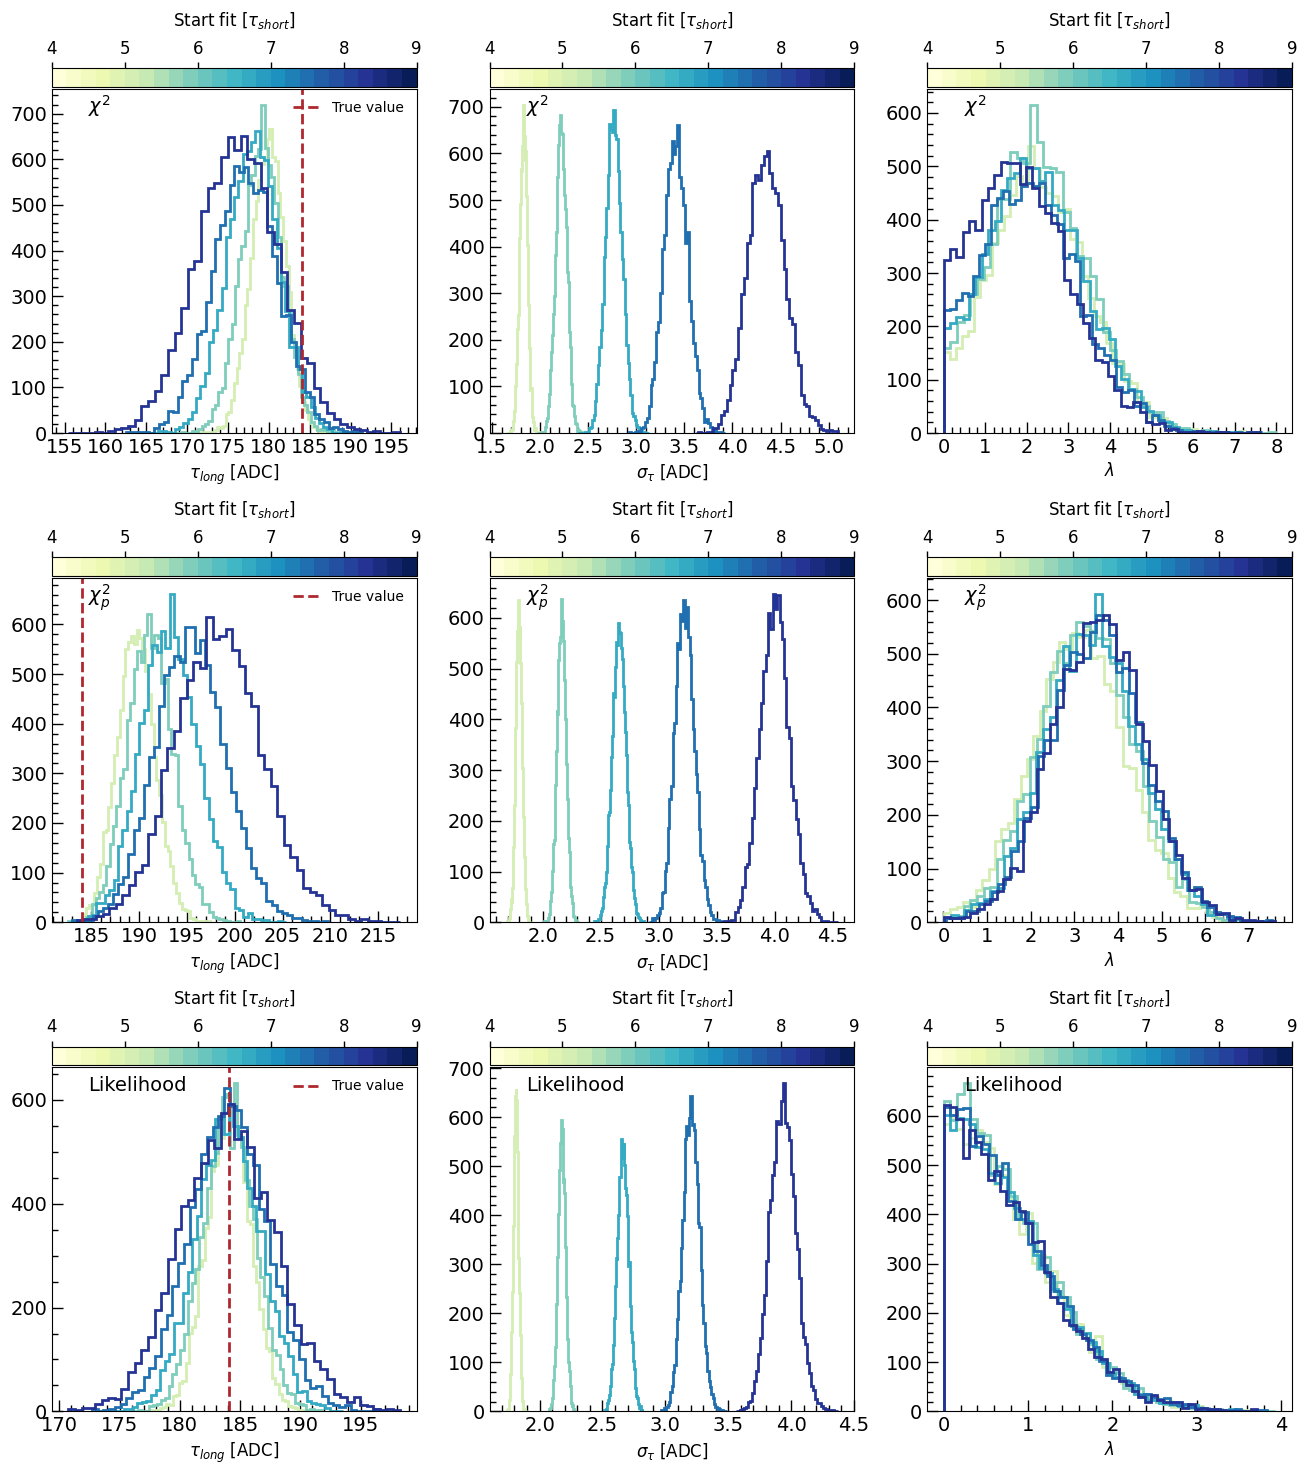

In [241]:
fig, ax = plt.subplots(3, 3, figsize = (16,18))


import matplotlib as mpl
c = np.arange(4,10)


#labels = ['$5\\tau$', '$6\\tau$', '$7\\tau$', '$8\\tau$', '$9\\tau$']
labels = ['$\chi^2$', '$\chi^2_p$', 'Likelihood']

for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',25)
    # Make dummie mappable
    dummie_cax = ax[0,k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[0,k].cla()  
    for i in range(0,5): 
        if k == 0: ax[0,k].hist(tree_tau_l.tau_chi[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 1: ax[0,k].hist(tree_tau_l.tau_chi_err[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 2: ax[0,k].hist(tree_tau_l.delta_chi[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[0,k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{short}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)


for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',25)
    # Make dummie mappable
    dummie_cax = ax[1,k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[1,k].cla()  
    for i in range(0,5): 
        if k == 0: ax[1,k].hist(tree_tau_l.tau_chip[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 1: ax[1,k].hist(tree_tau_l.tau_chip_err[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 2: ax[1,k].hist(tree_tau_l.delta_chip[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[1,k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{short}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)


for k in range(0,3):
    cmap = mpl.cm.get_cmap('YlGnBu',25)
    # Make dummie mappable
    dummie_cax = ax[2,k].scatter(c, c, c=c, cmap=cmap)
    # Clear axis
    ax[2,k].cla()  
    for i in range(0,5): 
        if k == 0: ax[2,k].hist(tree_tau_l.tau_LL[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 1: ax[2,k].hist(tree_tau_l.tau_LL_err[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))
        if k == 2: ax[2,k].hist(tree_tau_l.delta_L[:,i], bins=50, histtype='step', lw=2, alpha=1, align = 'mid', color=cmap(5+4*i))

    cb = fig.colorbar(dummie_cax, ticks=c, ax = ax[2,k], orientation = 'horizontal', location = 'top', pad = 0.005)
    cb.set_label(label = 'Start fit [$\\tau_{short}$]', fontsize = 12, labelpad=10)
    cb.ax.tick_params(which='major', width=1.0, length=4, direction='out', labelsize=12)


for i in range(0,3):
    ax[i,0].set_xlabel('$\\tau_{long}$ [ADC]', fontsize=12)
    ax[i,1].set_xlabel('$\\sigma_{\\tau}$ [ADC]', fontsize=12)
    ax[i,2].set_xlabel('$\\lambda$', fontsize=12)

    ax[i,0].axvline(tau_l_adc, lw = 2, ls = '--', color = '#AF272F', label = 'True value')
    ax[i,0].legend(loc='upper right', frameon=False, fontsize=10)

    ax[i,0].text(0.1, 0.93, labels[i], fontsize = 14, transform = ax[i,0].transAxes)
    ax[i,1].text(0.1, 0.93, labels[i], fontsize = 14, transform = ax[i,1].transAxes)
    ax[i,2].text(0.1, 0.93, labels[i], fontsize = 14, transform = ax[i,2].transAxes)

set_ticks(ax[0,0], 5, 100)
set_ticks(ax[0,1], 0.5, 100)
set_ticks(ax[0,2], 1, 100)
set_ticks(ax[1,0], 5,100)
set_ticks(ax[1,1], 0.5,100)
set_ticks(ax[1,2], 1,100)
set_ticks(ax[2,0], 5,200)
set_ticks(ax[2,1], 0.5,100)
set_ticks(ax[2,2], 1,100)

#fig.savefig('tau_long_exp.pdf', dpi = 200)
plt.show()